# Machine Learning Online Class - Exercise 2: Regularization

In [2]:
import numpy as np
from scipy.optimize import fmin_bfgs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3)

In [3]:
data = pd.read_csv("ex2data2.txt")
data.columns = ['chip test 1', 'chip test 2', 'y']
data.head()

,chip test 1,chip test 2,y
0,-0.092742,0.68494,1
1,-0.213710,0.69225,1
2,-0.375000,0.50219,1
3,-0.513250,0.46564,1
4,-0.524770,0.20980,1


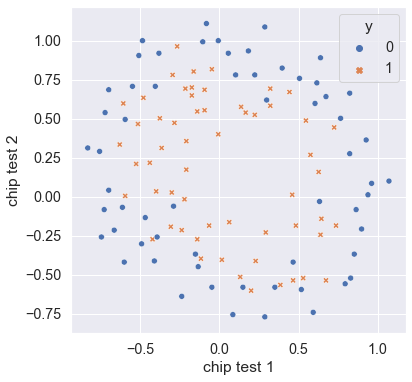

In [4]:
fig0, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, ax=ax, x='chip test 1', y='chip test 2', hue='y', style='y')

## =========== Part 1: Regularized Logistic Regression ============

In [5]:
#Add polynomial features to the data frame
data.insert(0, 'x0', [1 for i in range(len(data.index))])
degree = 6
for i in range(2,degree+1):
    for j in range(i+1):
        tag = 'x1^{0}x2^{1}'.format(i-j, j)
        #print(tag)
        data[tag] = data['chip test 1']**(i-j) * data['chip test 2']**(j)

#move y to the end
data = data[[c for c in data if c != 'y'] + ['y']]
data.head()

,x0,chip test 1,chip test 2,x1^2x2^0,x1^1x2^1,x1^0x2^2,x1^3x2^0,x1^2x2^1,x1^1x2^2,x1^0x2^3,...,x1^1x2^4,x1^0x2^5,x1^6x2^0,x1^5x2^1,x1^4x2^2,x1^3x2^3,x1^2x2^4,x1^1x2^5,x1^0x2^6,y
0,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,-0.020412,0.150752,6.362953e-07,-0.000005,0.000035,-0.000256,0.001893,-0.013981,0.103256,1
1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,-0.049077,0.158970,9.526844e-05,-0.000309,0.001000,-0.003238,0.010488,-0.033973,0.110047,1
2,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,-0.023851,0.031940,2.780914e-03,-0.003724,0.004987,-0.006679,0.008944,-0.011978,0.016040,1
3,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,-0.024128,0.021890,1.827990e-02,-0.016584,0.015046,-0.013650,0.012384,-0.011235,0.010193,1
4,1,-0.524770,0.20980,0.275384,-0.110097,0.044016,-0.144513,0.057775,-0.023098,0.009235,...,-0.001017,0.000406,2.088401e-02,-0.008349,0.003338,-0.001335,0.000534,-0.000213,0.000085,1


In [6]:
#Extract matrix X and convert to array
X = data.iloc[:,0:data.shape[1]-1].to_numpy()
#Extract vector y as a column vector
y = data.iloc[:,data.shape[1]-1].to_numpy()[np.newaxis].T #create a new axis to convert a 1d array to 2d and transpose
X.shape, y.shape

((117, 28), (117, 1))

By regularizing we avoid large values in any of the coefficients, thus making the curve smoother and avoiding overfitting. Regularized cost function for the logistic regression:
$$J(\vec{\theta})=-\frac{1}{m}\sum_{i=1}^m \left[y^{(i)}\log(h_{\theta}(\vec{x}^{(i)}))+(1-y^{(i)})\log(1-h_{\theta}(\vec{x}^{(i)}))\right]+\frac{\lambda}{2m}\sum_{k=1}^n\theta_k^2,$$
where the larger $\lambda$ is, the smaller the solution coeficients will be and thus the smoother the function will be. Note that the bias term (coeficient $\theta_0$) is not regularized. The gradient with respect to the coeficients is then

$$\frac{\partial J}{\partial\theta_k}=\left\{\begin{array}{lc}
\frac{1}{m}\sum_{i=1}^m\left[h_{\theta}(\vec{x}^{(i)})-y^{(i)}\right]x^{(i)}_k+\frac{\lambda}{m}\theta_k & ,\hspace{0.5cm}k\neq 0\\
\frac{1}{m}\sum_{i=1}^m\left[h_{\theta}(\vec{x}^{(i)})-y^{(i)}\right]x^{(i)}_k & ,\hspace{0.5cm}k= 0
\end{array}\right.
$$


In [7]:
#Logistic function
def logistic(theta, x):
    dot = np.matmul(x, theta)
    if type(dot) == np.ndarray:
        dot = dot[0]
    return 1.0 / (1 + np.exp(-dot))

def hv(theta, X):
    return np.array([[logistic(theta, x) for x in X]]).T

#Regularized cost function J
def Jreg(theta, X, y, l):
    hvec = hv(theta.reshape(X.shape[1],1), X)
    one = np.ones((y.shape[0],1))
    hvec1 = one-hvec
    logh = np.log(hvec)
    logh1 = np.log(hvec1)
    y1 = one-y
    
    dot1 = np.matmul(y.T,logh)
    dot2 = np.matmul(y1.T,logh1)
    
    thetam = np.copy(theta)
    thetam[0] = 0
    fact = l / (2*y.shape[0])
    tsum = np.sum(fact*thetam**2)
    
    return -(dot1[0][0]+dot2[0][0])/y.shape[0] + tsum

#Gradient of regularized J
def grad_Jreg(theta, X, y, l):
    hvec = hv(theta.reshape(X.shape[1],1), X)
    yh = hvec - y
    grad = []
    for k in range(X.shape[1]):
        xk = X[:,k] #k column as 1d array (row vector)
        grad.append(np.matmul(xk,yh))
        
    thetam = np.copy(theta)
    thetam[0] = 0
    fact = l / y.shape[0]
        
    return (np.asarray(grad)/y.shape[0]).flatten() + fact*thetam

In [8]:
test_theta = np.ones(X.shape[1])

cost = Jreg(test_theta, X, y, 10)
print("Cost at test theta (with lambda = 10): {0:.3f}".format(cost))
print("Expected cost (approx): 3.16")

grad = grad_Jreg(test_theta, X, y, 10)
print("Gradient at test theta -first five values only-: ")
print(grad.tolist()[:5])
print("Expected gradients (approx): 0.3460, 0.1614, 0.1948, 0.2269, 0.0922")

Cost at test theta (with lambda = 10): 3.191
Expected cost (approx): 3.16
Gradient at test theta -first five values only-: 
[0.349333056108217, 0.16274793065634213, 0.1966917638125636, 0.2288026485776635, 0.09298543400443102]
Expected gradients (approx): 0.3460, 0.1614, 0.1948, 0.2269, 0.0922


## ============= Part 2: Regularization and Accuracies =============
See how $\lambda$ affects the decision boundary and the training set accuracy

In [9]:
#Accuracy
def predict_acc(theta, X, y):
    tot = 0
    for i in range(X.shape[0]):
        py = 1 if logistic(theta, X[i]) > 0.5 else 0
        tot += 1 if py == y[i] else 0
    return tot / X.shape[0]

In [10]:
#Use lambda values: 0, 1, 10, 100
thetas = []
for l in [0,1,10,100]:
    theta_in = np.zeros(X.shape[1])
    theta_min = fmin_bfgs(Jreg, theta_in, grad_Jreg, args=(X, y, l))
    p = predict_acc(theta_min, X, y)
    thetas.append(theta_min)
    print("lambda {0}, accuracy: {1:.2f}".format(l, p))

Optimization terminated successfully.
         Current function value: 0.224768
         Iterations: 545
         Function evaluations: 546
         Gradient evaluations: 546
lambda 0, accuracy: 0.91
Optimization terminated successfully.
         Current function value: 0.530408
         Iterations: 46
         Function evaluations: 47
         Gradient evaluations: 47
lambda 1, accuracy: 0.83
Optimization terminated successfully.
         Current function value: 0.648308
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
lambda 10, accuracy: 0.75
Optimization terminated successfully.
         Current function value: 0.686287
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
lambda 100, accuracy: 0.61


In [39]:
def func(x1, x2, theta):
    d = []
    for i in range(degree+1):
        for j in range(i+1):
            d.append(x1**(i-j) * x2**j)
    d = np.asarray(d).reshape(1,X.shape[1])
    t = theta.reshape(X.shape[1],1)
    return np.matmul(d,t)[0][0]

In [74]:
x1vals = [x for x in np.arange(-1,1.3,0.05)]
x2vals = [x for x in np.arange(-1,1.3,0.05)]
fvals = []
for l in range(4):
    fvals.append(np.array([[func(i, j, thetas[l]) for i in x1vals] for j in x2vals]))

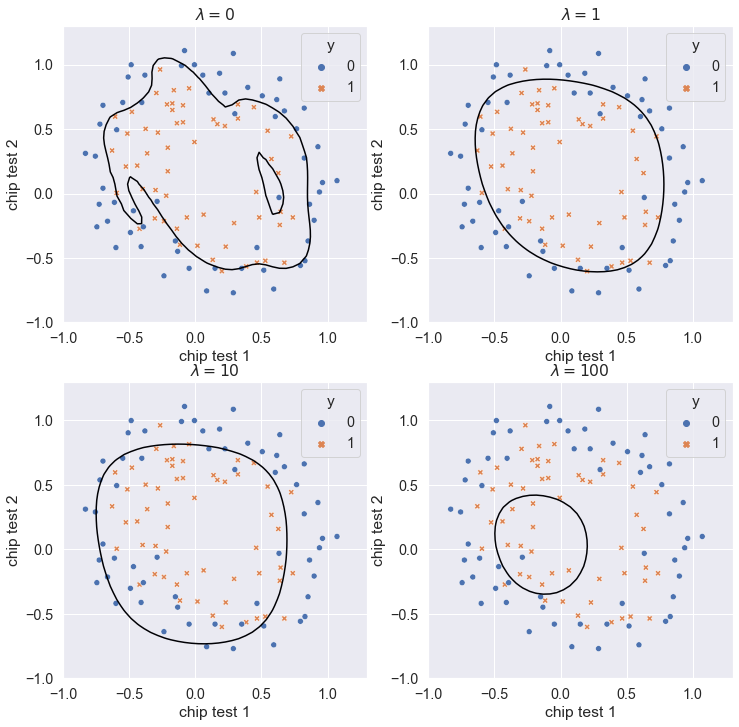

In [77]:
#the decision boundary is located where the polynomial = 0.0
fig1, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(12, 12))
ax0.set_title(r'$\lambda=0$')
sns.scatterplot(data=data, ax=ax0, x='chip test 1', y='chip test 2', hue='y', style='y')
ax0.contour(fvals[0],cmap='inferno',extent=[-1,1.3,-1,1.3],levels=[0.0])
ax1.set_title(r'$\lambda=1$')
sns.scatterplot(data=data, ax=ax1, x='chip test 1', y='chip test 2', hue='y', style='y')
ax1.contour(fvals[1],cmap='inferno',extent=[-1,1.3,-1,1.3],levels=[0.0])
ax2.set_title(r'$\lambda=10$')
sns.scatterplot(data=data, ax=ax2, x='chip test 1', y='chip test 2', hue='y', style='y')
ax2.contour(fvals[2],cmap='inferno',extent=[-1,1.3,-1,1.3],levels=[0.0])
ax3.set_title(r'$\lambda=100$')
sns.scatterplot(data=data, ax=ax3, x='chip test 1', y='chip test 2', hue='y', style='y')
ax3.contour(fvals[3],cmap='inferno',extent=[-1,1.3,-1,1.3],levels=[0.0])

We see that $\lambda=0$ overfits while $\lambda=10,100$ underfit.